1. Найти ближайшую пару
2. Построить диаграмму Вороного (любым алгоритмом)
3. Построить триангуляцию

Точки:
(0, 3.5)
(1, 1)
(2, 2)
(2.5, 4)
(3, 0)
(4, 3)
(5, 1.5)

In [9]:
import numpy as np

points = np.array([
    [0, 3.5],
    [1, 1],
    [2, 2],
    [2.5, 4],
    [3, 0],
    [4, 3],
    [5, 1.5]
])

In [10]:
def find_closest_pair(points):
    num_points = len(points)
    min_distance = float('inf')
    closest_pair = None

    for i in range(num_points - 1):
        for j in range(i + 1, num_points):
            distance = np.linalg.norm(points[i] - points[j])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (points[i], points[j])

    print(f"{closest_pair}, {min_distance}")

find_closest_pair(points)

(array([1., 1.]), array([2., 2.])), 1.4142135623730951


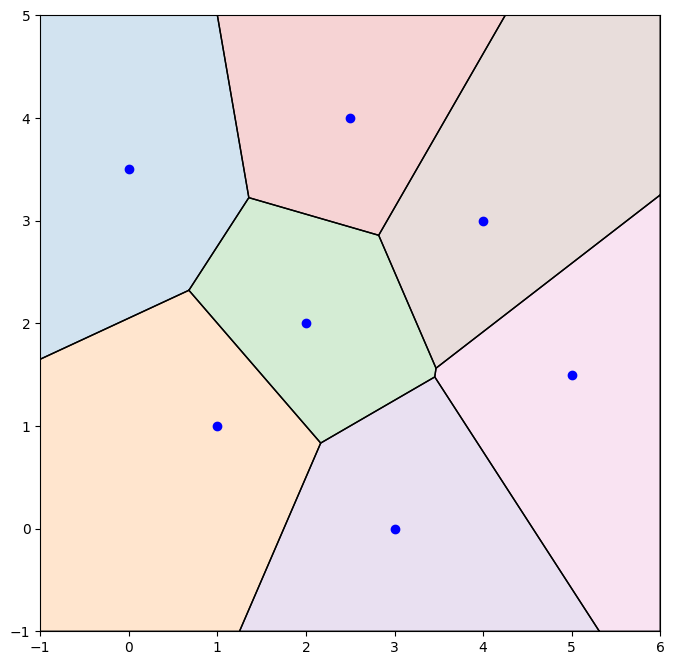

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def clip_polygon(polygon, A, B, C):
    new_poly = []
    n = len(polygon)
    for i in range(n):
        cur = polygon[i]
        nxt = polygon[(i + 1) % n]
        cur_inside = (A * cur[0] + B * cur[1]) <= C
        nxt_inside = (A * nxt[0] + B * nxt[1]) <= C
        if cur_inside:
            new_poly.append(cur)
        if cur_inside != nxt_inside:
            denom = A * (nxt[0] - cur[0]) + B * (nxt[1] - cur[1])
            t = (C - (A * cur[0] + B * cur[1])) / denom

            intersect_point = (cur[0] + t * (nxt[0] - cur[0]),
                               cur[1] + t * (nxt[1] - cur[1]))
            new_poly.append(intersect_point)
    return new_poly

def compute_voronoi_cell(p, others, bbox):
    cell = bbox.copy()
    for q in others:
        A = 2 * (q[0] - p[0])
        B = 2 * (q[1] - p[1])
        C = (q[0]**2 + q[1]**2) - (p[0]**2 + p[1]**2)
        cell = clip_polygon(cell, A, B, C)
        if not cell:
            break
    return cell

min_x, min_y = np.min(points, axis=0) - 1
max_x, max_y = np.max(points, axis=0) + 1
bbox = [(min_x, min_y),
        (min_x, max_y),
        (max_x, max_y),
        (max_x, min_y)]

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(points[:,0], points[:,1], color='blue', zorder=5)

for i, p in enumerate(points):
    others = [q for j, q in enumerate(points) if j != i]
    cell = compute_voronoi_cell(p, others, bbox)
    if cell:
        cell = np.array(cell)
        ax.plot(np.append(cell[:,0], cell[0,0]), np.append(cell[:,1], cell[0,1]),
                'k-', lw=1)
        ax.fill(cell[:,0], cell[:,1], alpha=0.2)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
plt.show()

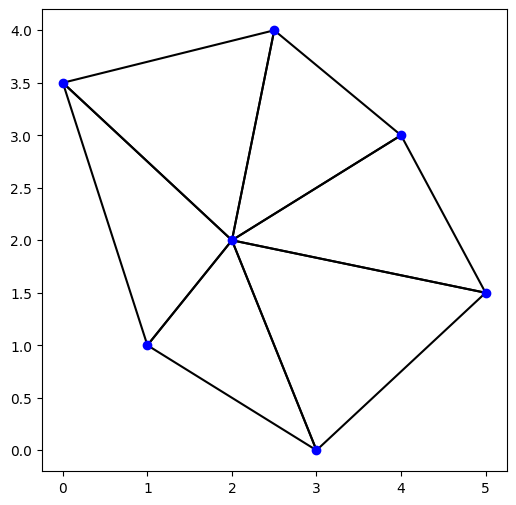

In [7]:

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def circumcircle(points):
    (x1, y1), (x2, y2), (x3, y3) = points

    d = 2 * (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    ux = ((x1**2 + y1**2)*(y2 - y3) + (x2**2 + y2**2)*(y3 - y1) + (x3**2 + y3**2)*(y1 - y2)) / d
    uy = ((x1**2 + y1**2)*(x3 - x2) + (x2**2 + y2**2)*(x1 - x3) + (x3**2 + y3**2)*(x2 - x1)) / d

    center = np.array([ux, uy])
    radius = sqrt((x1 - ux)**2 + (y1 - uy)**2)
    return center, radius

def is_point_in_circumcircle(point, center, radius):
    return np.linalg.norm(point - center) <= radius + 1e-12

def delaunay(points):
    n = len(points)
    triangles = []

    for i in range(n - 2):
        for j in range(i + 1, n - 1):
            for k in range(j + 1, n):
                center, radius = circumcircle((points[i], points[j], points[k]))
                if center is None:
                    continue

                valid_triangle = True
                for m in range(n):
                    if m == i or m == j or m == k:
                        continue
                    if is_point_in_circumcircle(points[m], center, radius):
                        valid_triangle = False
                        break
                if valid_triangle:
                    triangles.append((i, j, k))

    return triangles

def plot_delaunay(points, triangles):
    plt.figure(figsize=(6,6))
    plt.scatter(points[:,0], points[:,1], color='blue', zorder=5)

    for tri in triangles:
        p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
        x_coords = [p1[0], p2[0], p3[0], p1[0]]
        y_coords = [p1[1], p2[1], p3[1], p1[1]]
        plt.plot(x_coords, y_coords, color='black')

    plt.show()

triangles = delaunay(points)
plot_delaunay(points, triangles)
